# Random Forests
## This notebook outlines the main concepts behind the Random Forest with a real-world example

## Random Forest

### Random Forest = Decision Tree + Bagging + Random subsets of features

The Random Forest is a model made up of many `decision trees`. Rather than just simply averaging the prediction of trees (which we could call a **forest**), this model uses two key concepts that gives it the name random:
- Random sampling of training data points when building trees
- Random subsets of features considered when splitting nodes

To be more clear, this takes the idea of a single decision tree, and creates an _ensemble_ model out of hundreds or thousands of trees to reduce the variance. 

Each tree is trained on a random set of the observations, and for each split of a node, only a `subset of the features` are used for making a split. When making predictions, the random forest `averages the predictions` for each of the individual decision trees for each data point in order to arrive at a final classification.

### Bagging

### Random sampling of training observations

- **Training**: each tree in a random forest learns from a **random sample** of the data points. The samples are drawn with replacement, known as **bootstrapping**, which means that some samples will be used multiple times in a single tree. The idea is that by training each tree on different samples, although each tree might have high variance with respect to a particular set of the training data, overall, the entire forest will have lower variance but not at the cost of increasing the bias.

- **Testing**: predictions are made by **averaging the predictions** of each decision tree. This procedure of training each individual learner on different bootstrapped subsets of the data and then averaging the predictions is known as **bagging**, short for **bootstrap aggregating**.

### Random Subsets of features for splitting nodes
Only a subset of all the features are considered for splitting each node in each decision tree. Generally this is set to `sqrt(n_features)` for classification meaning that if there are 16 features, at each node in each tree, only 4 random features will be considered for splitting the node. 

### Let us see if our theory holds good in the same dataset we used for building Decision Tree

# Behavioral Risk Factor Surveillance System

[Behavioral Risk Factor Surveillance System](https://www.kaggle.com/cdc/behavioral-risk-factor-surveillance-system)

The objective of the BRFSS is to collect uniform, state-specific data on preventive health practices and risk behaviors that are linked to chronic diseases, injuries, and preventable infectious diseases in the adult population. Factors assessed by the BRFSS include tobacco use, health care coverage, HIV/AIDS knowledge or prevention, physical activity, and fruit and vegetable consumption. Data are collected from a random sample of adults (one per household) through a telephone survey.

The Behavioral Risk Factor Surveillance System (BRFSS) is the nation's premier system of health-related telephone surveys that collect state data about U.S. residents regarding their health-related risk behaviors, chronic health conditions, and use of preventive services. Established in 1984 with 15 states, BRFSS now collects data in all 50 states as well as the District of Columbia and three U.S. territories. BRFSS completes more than 400,000 adult interviews each year, making it the largest continuously conducted health survey system in the world.

The following data set is from the Centers for Disease Control and Prevention (CDC) and includes socioeconomic and lifestyle indicators for hundreds of thousands of individuals. The objective is to predict the overall health of an individual: either 0 for poor health or 1 for good health. We'll limit the data to 100,000 individuals to speed up training.

Or, if you have the gut to take it, please pass the entire data and have fun!!!

This problem is imbalanced (far more of one label than another) so for assessing performance, we'll use recall, precision, receiver operating characteristic area under the curve (ROC AUC), and also plot the ROC curve. Accuracy is not a useful metric when dealing with an imbalanced problem. **Why????**

## Data Acquisition
Go to Kaggle Competition page and pull the dataset of 2015

In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
RSEED=50

In [1]:
df = pd.read_csv('data/2015.csv').sample(100000, random_state = RSEED)
df.head()

NameError: name 'pd' is not defined

### Data Exploration
- Find how many features
- Find how many samples
- Find how many missing data
- Find how many categorical features
- And many more

In [5]:
df = df.select_dtypes('number')
df

,_STATE,FMONTH,DISPCODE,SEQNO,_PSU,CTELENUM,PVTRESD1,COLGHOUS,STATERES,CELLFON3,...,_PAREC1,_PASTAE1,_LMTACT1,_LMTWRK1,_LMTSCL1,_RFSEAT2,_RFSEAT3,_FLSHOT6,_PNEUMO2,_AIDTST3
383119,49.0,4.0,1100.0,2.015009e+09,2.015009e+09,NaN,NaN,NaN,NaN,NaN,...,4.0,2.0,3.0,3.0,4.0,1.0,1.0,NaN,NaN,2.0
55536,9.0,9.0,1100.0,2.015005e+09,2.015005e+09,1.0,1.0,NaN,1.0,1.0,...,2.0,2.0,3.0,3.0,4.0,1.0,1.0,NaN,NaN,2.0
267093,34.0,10.0,1100.0,2.015011e+09,2.015011e+09,NaN,NaN,NaN,NaN,NaN,...,4.0,2.0,3.0,3.0,4.0,1.0,1.0,NaN,NaN,2.0
319092,41.0,4.0,1100.0,2.015002e+09,2.015002e+09,1.0,1.0,NaN,1.0,1.0,...,2.0,2.0,2.0,2.0,3.0,1.0,1.0,2.0,1.0,2.0
420978,54.0,5.0,1100.0,2.015004e+09,2.015004e+09,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,3.0,3.0,4.0,1.0,1.0,NaN,NaN,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223705,30.0,1.0,1100.0,2.015001e+09,2.015001e+09,1.0,1.0,NaN,1.0,2.0,...,2.0,2.0,3.0,3.0,4.0,1.0,2.0,NaN,NaN,9.0
193441,27.0,3.0,1100.0,2.015001e+09,2.015001e+09,1.0,1.0,NaN,1.0,1.0,...,2.0,2.0,3.0,3.0,4.0,1.0,1.0,NaN,NaN,2.0
39766,8.0,7.0,1100.0,2.015002e+09,2.015002e+09,1.0,1.0,NaN,1.0,2.0,...,2.0,2.0,2.0,1.0,3.0,1.0,1.0,NaN,NaN,2.0
142057,21.0,7.0,1100.0,2.015003e+09,2.015003e+09,1.0,1.0,NaN,1.0,1.0,...,4.0,2.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,2.0


### Label Distribution
RFHLTH is the label for this dataset

### Explore the label

In [6]:
df['_RFHLTH']

383119    1.0
55536     1.0
267093    1.0
319092    1.0
420978    1.0
         ... 
223705    1.0
193441    1.0
39766     1.0
142057    1.0
386390    1.0
Name: _RFHLTH, Length: 100000, dtype: float64

### Find what are the values inside the label

In [7]:
df['_RFHLTH'].value_counts()

1.0    81140
2.0    18579
9.0      281
Name: _RFHLTH, dtype: int64

### Label feature
- Keep only 1.0 values
- Make 2.0 as 0.0 
- Discard all other values
- Rename the feature as `label`

In [8]:
df['_RFHLTH'] = df['_RFHLTH'].replace({2: 0})
df = df.loc[df['_RFHLTH'].isin([0, 1])].copy()
df = df.rename(columns = {'_RFHLTH': 'label'})
df['label'].value_counts()

1.0    81140
0.0    18579
Name: label, dtype: int64

### What do you see?

Some housekeeping to make things smooth...

In [9]:
# Remove columns with missing values
df = df.drop(columns = ['POORHLTH', 'PHYSHLTH', 'GENHLTH', 'PAINACT2', 
                        'QLMENTL2', 'QLSTRES2', 'QLHLTH2', 'HLTHPLN1', 'MENTHLTH'])

## Split Data into Training and Testing Set

Save 30% for testing

In [10]:
from sklearn.model_selection import train_test_split


labels = np.array(df.pop('label'))


train, test, train_labels, test_labels = train_test_split(df, labels, 
                                                          stratify = labels,
                                                          test_size = 0.3, 
                                                          random_state = RSEED)

#### Imputation of Missing values

We'll fill in the missing values with the mean of the column. It's important to note that we fill in missing values in the test set with the mean of columns in the training data. This is necessary because if we get new data, we'll have to use the training data to fill in any missing values. 

In [11]:
train = train.fillna(train.mean())
test = test.fillna(train.mean())

# Features for feature importances, we will use this later below in this notebook
features = list(train.columns)

In [12]:
train.shape

(69803, 313)

In [13]:
test.shape

(29916, 313)

## Random Forest Classifier

- Train the Random Forest on the data
- Unlimited depth 
- Is there overfitting???

### Import the RandomForestClassifier

In [14]:
from sklearn.ensemble import RandomForestClassifier

### Build the RandomForestClassifier

In [15]:
model = RandomForestClassifier(n_estimators=100, 
                               random_state=RSEED, 
                               max_features = 'sqrt',
                               n_jobs=-1, verbose = 1)

### Fit the model

In [16]:
model.fit(train, train_labels)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   23.7s finished


RandomForestClassifier(max_features='sqrt', n_jobs=-1, random_state=50,
                       verbose=1)

### Node count and Maximum depth of the tree

In [17]:
n_nodes = []
max_depths = []

for ind_tree in model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of nodes 13396
Average maximum depth 46


## Assessing Random Forest Performance

In [18]:
train_rf_predictions = model.predict(train)
train_rf_probs = model.predict_proba(train)[:, 1]

rf_predictions = model.predict(test)
rf_probs = model.predict_proba(test)[:, 1]

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.7s finished


### Plot ROC AUC Score

In [19]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve

print(f'Train ROC AUC Score: {roc_auc_score(train_labels, train_rf_probs)}')
print(f'Test ROC AUC  Score: {roc_auc_score(test_labels, rf_probs)}')

Train ROC AUC Score: 1.0
Test ROC AUC  Score: 0.8715984032347092


In [20]:
print(f'Baseline ROC AUC: {roc_auc_score(test_labels, [1 for _ in range(len(test_labels))])}')

Baseline ROC AUC: 0.5


Our model does outperform a baseline guess, but we can see it has severely overfit to the training data, acheiving perfect ROC AUC.

## Evaluation of Decision Tree
- 1. ROC AUC Curve
- 2. Confusion Matrix

We'll write a short function that calculates a number of metrics for the baseline (guessing the most common label in the training data), the testing predictions, and the training predictions. The function also plots the ROC curve where a better model is to the left and towards the top. 

### Helper function to evaluate model

In [21]:
def evaluate_model(predictions, probs, train_predictions, train_probs):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    baseline = {}
    
    baseline['recall'] = recall_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['precision'] = precision_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(test_labels, predictions)
    results['precision'] = precision_score(test_labels, predictions)
    results['roc'] = roc_auc_score(test_labels, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(train_labels, train_predictions)
    train_results['precision'] = precision_score(train_labels, train_predictions)
    train_results['roc'] = roc_auc_score(train_labels, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(test_labels, [1 for _ in range(len(test_labels))])
    model_fpr, model_tpr, _ = roc_curve(test_labels, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves');


In [23]:
from collections import Counter
print(Counter(rf_probs))
print(Counter(rf_predictions))

Counter({1.0: 2524, 0.99: 2225, 0.98: 1884, 0.97: 1542, 0.96: 1271, 0.95: 1206, 0.94: 1013, 0.93: 907, 0.92: 875, 0.91: 772, 0.9: 670, 0.89: 667, 0.88: 595, 0.87: 536, 0.85: 533, 0.86: 488, 0.82: 461, 0.84: 452, 0.83: 411, 0.8: 405, 0.78: 370, 0.79: 349, 0.81: 348, 0.77: 332, 0.76: 327, 0.75: 320, 0.72: 279, 0.73: 275, 0.74: 273, 0.7: 265, 0.68: 247, 0.69: 246, 0.67: 239, 0.71: 233, 0.66: 230, 0.62: 216, 0.63: 212, 0.61: 196, 0.64: 196, 0.65: 194, 0.59: 187, 0.57: 185, 0.56: 183, 0.6: 179, 0.55: 171, 0.58: 169, 0.54: 160, 0.51: 157, 0.48: 150, 0.52: 148, 0.5: 146, 0.53: 145, 0.49: 143, 0.45: 130, 0.44: 128, 0.47: 127, 0.46: 127, 0.37: 122, 0.4: 121, 0.42: 121, 0.41: 116, 0.39: 115, 0.35: 115, 0.43: 112, 0.36: 111, 0.32: 106, 0.38: 105, 0.33: 105, 0.3: 91, 0.29: 84, 0.34: 81, 0.31: 78, 0.26: 78, 0.28: 76, 0.25: 76, 0.27: 75, 0.22: 70, 0.23: 59, 0.24: 54, 0.21: 54, 0.19: 51, 0.2: 46, 0.18: 45, 0.17: 37, 0.16: 32, 0.13: 27, 0.14: 23, 0.12: 22, 0.15: 19, 0.11: 17, 0.09: 17, 0.1: 13, 0.08: 

Recall Baseline: 1.0 Test: 0.87 Train: 1.0
Precision Baseline: 0.81 Test: 0.88 Train: 1.0
Roc Baseline: 0.5 Test: 0.68 Train: 1.0


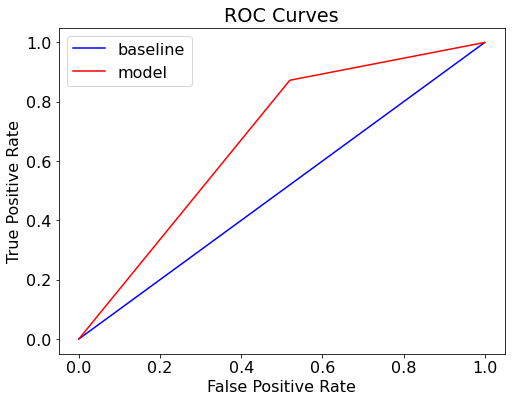

In [26]:
# Decision Tree ROC Curve

Recall Baseline: 1.0 Test: 0.96 Train: 1.0
Precision Baseline: 0.81 Test: 0.88 Train: 1.0
Roc Baseline: 0.5 Test: 0.87 Train: 1.0


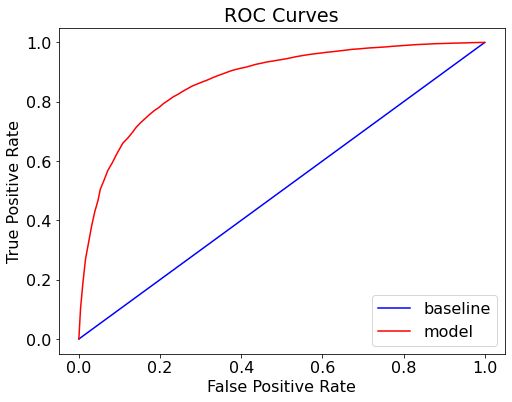

In [24]:
evaluate_model(rf_predictions, rf_probs, train_rf_predictions, train_rf_probs)

The model still achieves perfect measures on the training data, but this time, the testing scores are much better. If we compare the ROC AUC, we see that the random forest does significantly better than a single decision tree. 

### Confusion Matrix

In [25]:
from sklearn.metrics import confusion_matrix
import itertools

#  Helper function to plot Confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

Confusion matrix, without normalization
[[ 2677  2897]
 [ 3103 21239]]


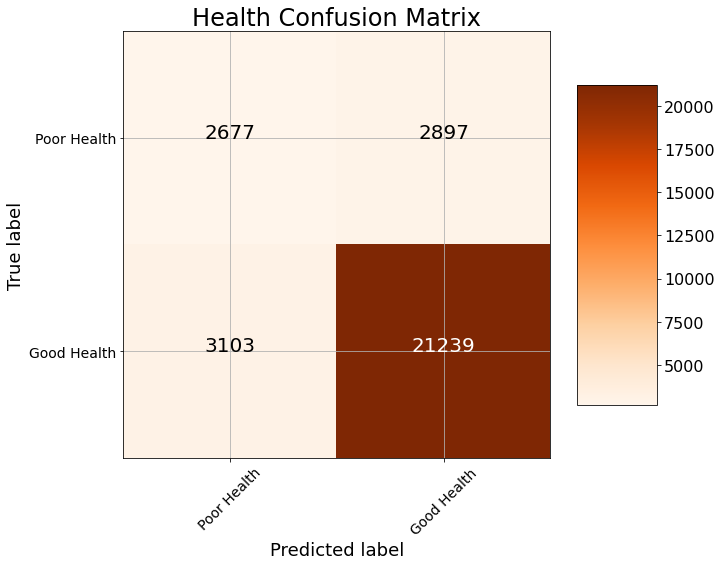

In [30]:
# Decision Tree Confusion Matrix

### Random Forest Confusion Matrix

Confusion matrix, without normalization
[[ 2437  3137]
 [ 1011 23331]]


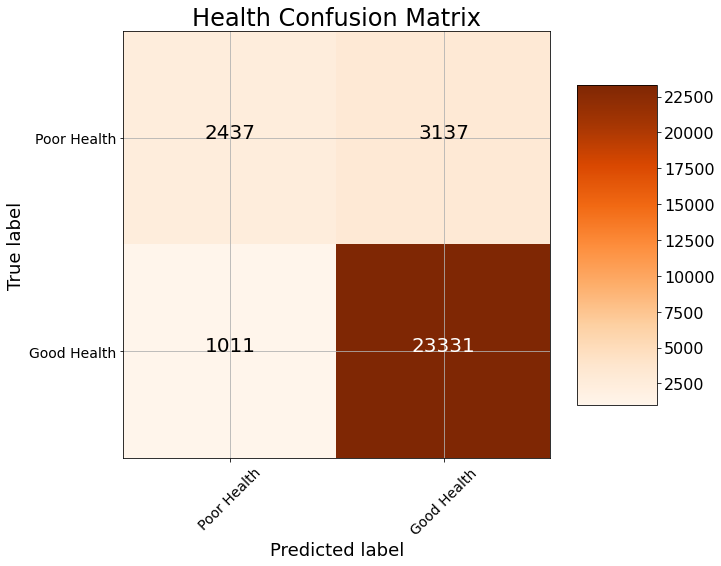

In [26]:
cm = confusion_matrix(test_labels, rf_predictions)
plot_confusion_matrix(cm, classes = ['Poor Health', 'Good Health'],
                      title = 'Health Confusion Matrix')

### Summary
Compared to the single decision tree, the model has fewer false postives although more false negatives.

__Overall, the random forest does significantly better than a single decision tree__. 

So, Random Forests work way better than a single Decision Tree and generalizes pretty well too avoiding or reducing overfitting.